In [1]:
%pip install pandas
%pip install scipy
%pip install torch
%pip install tensorflow
%pip install keras
%pip install statsmodels
%pip install keyboard
%pip install tqdm

  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 20.6 MB/s eta 0:00:00 0:00:01
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 24.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 21.5 MB/s eta 0:00:00a 0:00:01
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/

In [1]:
import os
new_directory = "/Users/joshlipman/OneDrive - Stanford/Research/Neural_Network_Chemistry_for_CFD"  # Replace with your desired path
os.chdir(new_directory)
print("New Working Directory:", os.getcwd())


New Working Directory: /Users/joshlipman/Library/CloudStorage/OneDrive-Stanford/Research/Neural_Network_Chemistry_for_CFD


In [93]:
from tensorflow.keras.models import load_model

nn_3 = load_model("./NN_3_1ns/ffcm1_Ar_dt=1ns_eq_TP_weighted.h5")

In [98]:
#FOR NN3
import numpy as np
import torch
mean_input = np.array([2957.432525595368, 2.5302383202484555, -5.436548790022723, -4.103226189385397, -4.696586724608626, -2.882590306507168, -4.382794890417709, -3.7925200917271154, -6.789082067317951, -7.730256237954359, -8.57845020393275])
std_input = np.array([501.07125754475754, 1.7022599071194513, 1.3143183966790397, 0.3663628173711173, 1.8084071398707917, 0.5593134248724109, 1.9575447830765766, 2.344167170267116, 0.6398534309446826, 0.5411979820006582, 0.36326197658822096])
mean_output = np.array([-0.021694017081708962, -1.9943791552458082e-05, 0.03947308101104838, -0.00028637719260077754, 0.038695189078792845, -0.00043291086288205666, 0.04503887035518625, 0.03699392413822824, 0.05473394303668766, 0.03719998314538324, 0.017513871639470904])
std_output = np.array([0.15385433191361458, 0.00023139109658889897, 0.15164137575312034, 0.0007231821106961492, 0.1404119577130132, 0.0010320843141902085, 0.16387780798245183, 0.1326489729671735, 0.21462732325567518, 0.1403125865924669, 0.07068845703180292])

import numpy as np

def boxcox(arr, lam=0.1):
    return (arr**lam - 1) / lam


def boxcox_inv(arr, lam=0.1):
    return (arr * lam + 1) ** (1 / lam)

import numpy as np

def predict_combustion(input):
    print("input: ", input)
    input_state = np.concatenate([np.array([input[0], input[1]]), boxcox(np.maximum(input[2:], 0))])    # Box-Cox transform with lambda = 0.1 for elements from index 2 onward
    print("after boxcox: ", input_state)
    input_state = (input_state - mean_input) / std_input
    print("After Norm: ", input_state)
    input_state = torch.FloatTensor(input_state.reshape(1, -1))
    model_output = nn_3(input_state)  # This function must return a shape-(11,) array-like
    output_real = model_output.numpy().flatten()
    print("after NN: ", output_real)

    output_real = output_real * std_output + mean_output

    print("after undo norm: ", output_real)

    input_real = input_state.numpy().flatten()
    input_real = input_real * std_input + mean_input
    output_real += input_real
    output_real[2:] = np.maximum(boxcox_inv(output_real[2:]), 0)
    print("after all: ", output_real)
    return output_real


In [ ]:
import cantera as ct
input = np.array([2500, 2, 0, 0.0127722113, 0, 0.1013689888, 0, 0, 0, 0, 0])

total_time_steps = 10000
#Change path to mechanism here as needed

n_steps_cantera = 1 #Number fo time steps cantera will run concecutively


history_of_states = np.zeros((total_time_steps, 11))
history_of_states[0] = input
print(input)
for i in range(1, total_time_steps):
    print(i)
    if i % 10 != 0:   #USE NN switch value here to change frequency of cantera usage. i % 10 uses cantera once every 10 timesteps
        next_state = predict_combustion(input)

        # Start with Ar mass fraction
        run_sum = 0.8858587999

        # Zero out negatives and accumulate the sum from index 2 to 10
        for j in range(2, 11):
            next_state[j] = max(0.0, next_state[j])
            run_sum += next_state[j]

        print(f"runsum with everything: {run_sum}")

        # Normalize elements from index 2 to 10 so total sum = 1
        for j in range(2, 11):
            next_state[j] = next_state[j] / run_sum
        history_of_states[i] = next_state


        input = next_state


    else:   #USE CANTERA
        gas = ct.Solution("H2_FFCM1_O3_Ar.yaml")

        Ar_massfrac = 1 - (input[2] + input[3] + input[4] + input[5] + input[6] + input[7] + input[8] + input[9] + input[10])
        mass_frac_list = f"H:{input[2]},H2:{input[3]},O:{input[4]},O2:{input[5]},OH:{input[6]},H2O:{input[7]},HO2:{input[8]},H2O2:{input[9]},O3:{input[10]},AR:{Ar_massfrac}"
        gas.TPY = input[0], input[1] * 101325, mass_frac_list #K, Pa, massfarcs
        reactor = ct.IdealGasReactor(gas)
        network = ct.ReactorNet([reactor])
        dt = 1e-9
        x = np.zeros(11)
        #Order: "H", "H2", "O", "O2", "OH", "H2O", "HO2", "H2O2", "O3", NOT "AR"
        j = 0
        network.advance(dt)
        #   x[j, 0] = network.time
        x[0] = reactor.T
        x[1] = reactor.thermo.P / 101325
        x[2] = gas.mass_fraction_dict().get('H', 0.0)
        x[3] = gas.mass_fraction_dict().get('H2', 0.0)
        x[4] = gas.mass_fraction_dict().get('O', 0.0)
        x[5] = gas.mass_fraction_dict().get('O2', 0.0)
        x[6] = gas.mass_fraction_dict().get('OH', 0.0)
        x[7] = gas.mass_fraction_dict().get('H2O', 0.0)
        x[8] = gas.mass_fraction_dict().get('HO2', 0.0)
        x[9] = gas.mass_fraction_dict().get('H2O2', 0.0)
        x[10] = gas.mass_fraction_dict().get('O3', 0.0)
           # x[i, 12] = gas.mass_fraction_dict().get('AR', 0.0)
        input = np.array([x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10]])
        history_of_states[i] = input
        print(input)



[2.50000000e+03 2.00000000e+00 0.00000000e+00 1.27722113e-02
 0.00000000e+00 1.01368989e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
1
[2.49999373e+03 1.99999498e+00 1.45506359e-08 1.27721822e-02
 5.96750544e-10 1.01368528e-01 5.42717651e-10 5.71092536e-12
 4.73593539e-07 8.83585947e-11 1.63436206e-12]
2
[2.49998744e+03 1.99998996e+00 2.90517232e-08 1.27721532e-02
 2.17680077e-09 1.01368066e-01 2.17031108e-09 4.56478352e-11
 9.46804526e-07 3.50381810e-10 3.28473472e-12]
3
[2.49998115e+03 1.99998493e+00 4.35071278e-08 1.27721241e-02
 4.70877784e-09 1.01367602e-01 4.88135467e-09 1.54003977e-10
 1.41963269e-06 7.81575054e-10 4.95109954e-12]
4
[2.49997484e+03 1.99997989e+00 5.79206395e-08 1.27720950e-02
 8.16247181e-09 1.01367137e-01 8.67369956e-09 3.64916378e-10
 1.89207778e-06 1.37755806e-09 6.63343732e-12]
5
[2.49996853e+03 1.99997485e+00 7.22959729e-08 1.27720658e-02
 1.25087944e-08 1.01366669e-01 1.35445237e-08 7.12443627e-10
 2.36413952e-06 2.13406

Just Cantera:

In [148]:
#Change path to mechanism of choice for cantera run. Use the same mechansim that was used in NN training
gas = ct.Solution("H2_FFCM1_O3_Ar.yaml")


gas.TPX = 2500, 2*101325, "H2:2, O2:1, AR:7"
reactor = ct.IdealGasReactor(gas)
network = ct.ReactorNet([reactor])

# Make sure the timesteps here matches the time steps you simulated the NN for
n_steps = 10000 # Number of time steps
time_end = n_steps * 1e-9  # Convert ns to seconds

time = np.linspace(0, time_end, n_steps)

data = []
x = np.zeros((n_steps, 13))
#Order: "H", "H2", "O", "O2", "OH", "H2O", "HO2", "H2O2", "O3", NOT "AR"
i = 0
for t in time:
    network.advance(t)
    x[i, 0] = network.time
    x[i, 1] = reactor.T
    x[i, 2] = reactor.thermo.P / 101325
    x[i, 3] = gas.mass_fraction_dict().get('H', 0.0)
    x[i, 4] = gas.mass_fraction_dict().get('H2', 0.0)
    x[i, 5] = gas.mass_fraction_dict().get('O', 0.0)
    x[i, 6] = gas.mass_fraction_dict().get('O2', 0.0)
    x[i, 7] = gas.mass_fraction_dict().get('OH', 0.0)
    x[i, 8] = gas.mass_fraction_dict().get('H2O', 0.0)
    x[i, 9] = gas.mass_fraction_dict().get('HO2', 0.0)
    x[i, 10] = gas.mass_fraction_dict().get('H2O2', 0.0)
    x[i, 11] = gas.mass_fraction_dict().get('O3', 0.0)
    x[i, 12] = gas.mass_fraction_dict().get('AR', 0.0)
    i = i+1

(10000,)


/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_10865/2125633260.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


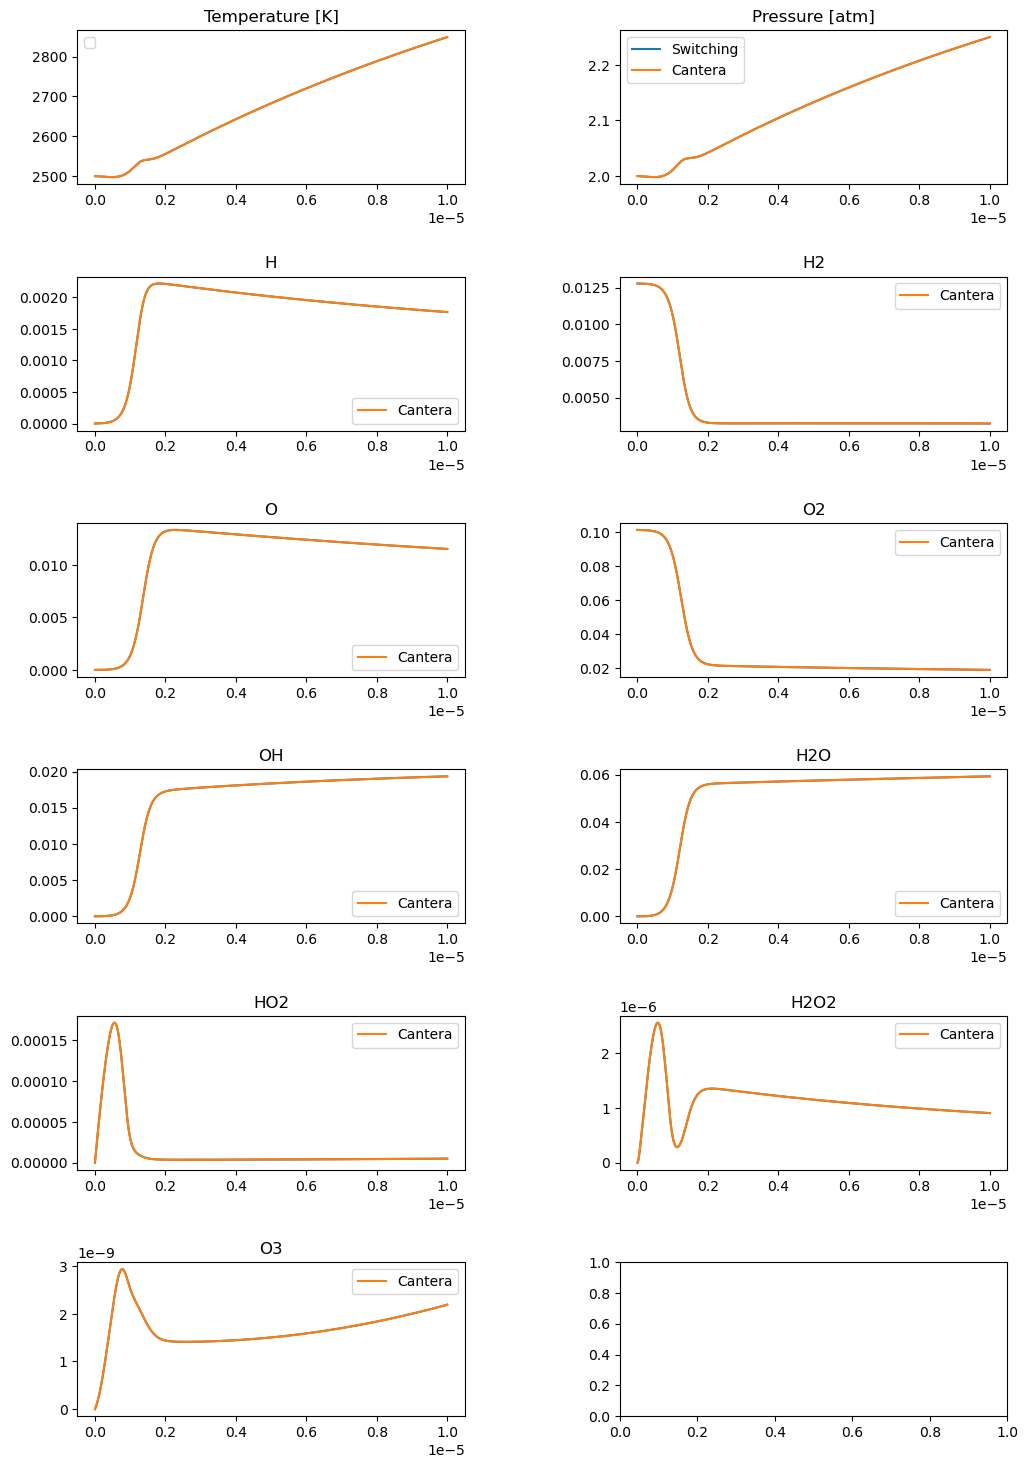

In [149]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 18))  # Increase figure size
axes = axes.flatten()  # Flatten to make indexing easier

# Flatten axes array for easier indexing
axes = axes.flatten()

time = np.linspace(0, total_time_steps*1e-9, total_time_steps)
axes[0].plot(time, history_of_states[:,0])
print(time.shape)
axes[0].plot(time, x[:,1])
axes[0].set_title('Temperature [K]')
axes[0].legend()

axes[1].plot(time, history_of_states[:,1], label = "Switching")
axes[1].plot(time, x[:,2], label = "Cantera")
axes[1].set_title('Pressure [atm]')
axes[1].legend()

axes[2].plot(time, history_of_states[:,2])
axes[2].plot(time, x[:,3], label = "Cantera")
axes[2].set_title('H')
axes[2].legend()

axes[3].plot(time, history_of_states[:,3])
axes[3].plot(time, x[:,4], label = "Cantera")
axes[3].set_title('H2')
axes[3].legend()


axes[4].plot(time, history_of_states[:,4])
axes[4].plot(time, x[:,5], label = "Cantera")
axes[4].set_title('O')
axes[4].legend()

axes[5].plot(time, history_of_states[:,5])
axes[5].plot(time, x[:,6], label = "Cantera")
axes[5].set_title('O2')
axes[5].legend()

axes[6].plot(time, history_of_states[:,6])
axes[6].plot(time, x[:,7], label = "Cantera")
axes[6].set_title('OH')
axes[6].legend()

axes[7].plot(time, history_of_states[:,7])
axes[7].plot(time, x[:,8], label = "Cantera")
axes[7].set_title('H2O')
axes[7].legend()

axes[8].plot(time, history_of_states[:,8])
axes[8].plot(time, x[:,9], label = "Cantera")
axes[8].set_title('HO2')
axes[8].legend()

axes[9].plot(time, history_of_states[:,9])
axes[9].plot(time, x[:,10], label = "Cantera")
axes[9].set_title('H2O2')
axes[9].legend()

axes[10].plot(time, history_of_states[:,10])
axes[10].plot(time, x[:,11], label = "Cantera")
axes[10].set_title('O3')
axes[10].legend()

fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

3.9.2
